# Correlation analysis

Running correlation on differentially expressed genes in inflammation datasets

### Setup

In [12]:
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr

In [2]:
ORTHOLOG_MAPPING_FILE = "data/mouse_orthology/human_mouse_orthologs.csv"

DGE_DIR = "data/dge"

In [3]:
human_burn = ad.read_h5ad(f"{DGE_DIR}/human_burn_dge.h5ad")
human_trauma = ad.read_h5ad(f"{DGE_DIR}/human_trauma_dge.h5ad")
human_sepsis = ad.read_h5ad(f"{DGE_DIR}/human_sepsis_dge.h5ad")

mouse_burn = ad.read_h5ad(f"{DGE_DIR}/mouse_burn_dge.h5ad")
mouse_trauma = ad.read_h5ad(f"{DGE_DIR}/mouse_trauma_dge.h5ad")
mouse_sepsis = ad.read_h5ad(f"{DGE_DIR}/mouse_sepsis_dge.h5ad")
mouse_infection = ad.read_h5ad(f"{DGE_DIR}/mouse_infection_dge.h5ad")

datasets_dict = {
    'human_burn': {'adata': human_burn, 'species': 'human'},
    'human_trauma': {'adata': human_trauma, 'species': 'human'},
    'human_sepsis': {'adata': human_sepsis, 'species': 'human'},
    'mouse_burn': {'adata': mouse_burn, 'species': 'mouse'},
    'mouse_trauma': {'adata': mouse_trauma, 'species': 'mouse'},
    'mouse_sepsis': {'adata': mouse_sepsis, 'species': 'mouse'},
    'mouse_infection': {'adata': mouse_infection, 'species': 'mouse'}
}

### Mapping orthologs

In [4]:
ortholog_mapping = pd.read_csv(ORTHOLOG_MAPPING_FILE)

### Poorly mimics

The maximum fold changes of gene expression were measured in log scale between patients and healthy subjects for each dataset of human burn, trauma, and endotoxemia and between treated and control groups for the corresponding murine models. Between two datasets, the agreements of the maximum gene fold changes (R2) as well as directionality of the changes (%) were compared. R2 represents the square of Pearson correlation. Similar results were seen when the rank correlation was calculated as in SI Appendix, Fig. S1. Percent represents the percentages of genes changed to the same direction between the two datasets.

#### Get significant genes

In [5]:
def get_human_significant_genes(human_dfs):
    significant_genes = set()

    for df in human_dfs:
        sig_genes = df[df['significant']].index.astype(int).tolist()
        significant_genes.update(sig_genes)

    return significant_genes

human_dfs = [human_burn.var, human_trauma.var, human_sepsis.var]
significant_human_genes = get_human_significant_genes(human_dfs)

In [6]:
# check how many of these genes have mouse orthologs
orthologs = ortholog_mapping[ortholog_mapping['human_entrez'].isin(significant_human_genes)]
print(f"Number of significant human genes with mouse orthologs: {orthologs['human_entrez'].nunique()}")

Number of significant human genes with mouse orthologs: 1970


In [7]:
limited_mouse_genes = ortholog_mapping.loc[
    ortholog_mapping['human_entrez'].isin(significant_human_genes), 'mouse_entrez'
].astype(str).tolist()
print(f"Number of mouse orthologs: {len(limited_mouse_genes)}")

Number of mouse orthologs: 2531


We have human genes mapping to more than one mouse ortholog.

In [8]:
# orthologs dataframe is already exploded and limited to significant genes
orthologs

,human_symbol,human_entrez,mouse_entrez
44,ABCA7,10347,27403
50,ABCB10,23456,56199
55,ABCB7,22,11306
70,ABCD3,5825,19299
72,ABCE1,6059,24015
...,...,...,...
28794,ZNF93,81931,432769
28807,ZNHIT6,54680,229937
28837,ZSCAN29,146050,99334
28863,ZWINT,11130,52696


In [9]:
# convert human_entrez and mouse_entrez to str for consistency
orthologs['human_entrez'] = orthologs['human_entrez'].astype(str)
orthologs['mouse_entrez'] = orthologs['mouse_entrez'].astype(str)

/tmp/ipykernel_757541/422181434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orthologs['human_entrez'] = orthologs['human_entrez'].astype(str)
/tmp/ipykernel_757541/422181434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orthologs['mouse_entrez'] = orthologs['mouse_entrez'].astype(str)


#### Recreating figure 1

In [ ]:
def compute_metrics(fc_x, fc_y):
    print(fc_x, fc_y)
    r, _ = pearsonr(fc_x, fc_y)
    r2 = r**2
    same_direction = (fc_x * fc_y > 0).sum()
    percent_same = same_direction / len(fc_x) * 100
    rho, _ = spearmanr(fc_x, fc_y)
    return {'R2_Pearson': r2, 'Percent_Same_Direction': percent_same, 'Spearman_rho': rho}

def plot_metrics_text(ax, metrics):
    text = f"R²={metrics['R2_Pearson']:.2f}\n" \
           f"%Dir={metrics['Percent_Same_Direction']:.1f}\n" \
           f"Spearman={metrics['Spearman_rho']:.2f}"
    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=12)

    # Keep a normal frame (spines) but remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)  # shows the outside box

def plot_scatter_fc(ax, fc_x, fc_y):
    ax.scatter(fc_x, fc_y, s=10, alpha=0.6)
    # ax.set_xticks([])
    # ax.set_yticks([])

    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, color='red', lw=1)

    for spine in ax.spines.values():
        spine.set_visible(True)

    # set x and y limits
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

def get_fc_vectors(dataset_i, dataset_j, orthologs_df):
    """
    Return aligned FC vectors for any pair of datasets.
    - Restricts to intersection of significant genes in both datasets.
    - Assumes human dataset is always passed first in cross-species comparisons.
    """
    adata_i, adata_j = dataset_i['adata'], dataset_j['adata']
    species_i, species_j = dataset_i['species'], dataset_j['species']

    # human-human
    if species_i == 'human' and species_j == 'human':
        sig_i = set(adata_i.var.index[adata_i.var['significant']])
        sig_j = set(adata_j.var.index[adata_j.var['significant']])
        genes = list(sig_i & sig_j)
        return (adata_i.var.loc[genes, 'log2FC'].astype(float).to_numpy(),
                adata_j.var.loc[genes, 'log2FC'].astype(float).to_numpy(),
                len(genes))

    # mouse-mouse
    elif species_i == 'mouse' and species_j == 'mouse':
        sig_i = set(adata_i.var.index[adata_i.var['significant']])
        sig_j = set(adata_j.var.index[adata_j.var['significant']])
        genes = list(sig_i & sig_j)
        return (adata_i.var.loc[genes, 'log2FC'].astype(float).to_numpy(),
                adata_j.var.loc[genes, 'log2FC'].astype(float).to_numpy(),
                len(genes))

    # human-mouse
    else:
        human_var, mouse_var = adata_i.var, adata_j.var
        sig_h = set(human_var.index[human_var['significant']])
        sig_m = set(mouse_var.index[mouse_var['significant']])

        fc_human_list, fc_mouse_list = [], []

        for h in sig_h:
            if h not in human_var.index:
                continue
            mouse_orthologs = orthologs_df.loc[
                orthologs_df['human_entrez'] == h, 'mouse_entrez'
            ].tolist()
            # only orthologs that are also significant
            mouse_orthologs = [m for m in mouse_orthologs if m in sig_m]
            if not mouse_orthologs:
                continue

            fc_human_list.extend([float(human_var.loc[h, 'log2FC'])] * len(mouse_orthologs))
            fc_mouse_list.extend(mouse_var.loc[mouse_orthologs, 'log2FC'].astype(float).tolist())

        return np.array(fc_human_list, dtype=float), np.array(fc_mouse_list, dtype=float), len(fc_human_list)


def make_comparison_grid(datasets_dict, orthologs_df):
    """
    Create a comparison grid:
    - Diagonal: dataset names
    - Upper triangle: metrics
    - Lower triangle: scatter
    """
    dataset_names = list(datasets_dict.keys())
    n = len(dataset_names)
    fig, axes = plt.subplots(n, n, figsize=(3*n, 3*n))

    # Precompute all FC vectors
    fc_vectors = {}
    for i, name_i in enumerate(dataset_names):
        for j, name_j in enumerate(dataset_names):
            if j < i:
                # Reuse the symmetric pair
                fc_vectors[(i,j)] = fc_vectors[(j,i)]
            else:
                vectors = get_fc_vectors(datasets_dict[name_i], datasets_dict[name_j], orthologs_df)
                print(f"Computed FC vectors for {name_i} vs {name_j}, lengths: {len(vectors[0])}, {len(vectors[1])}")
                fc_vectors[(i,j)] = vectors

    # Diagonal: dataset names
    for i, name in enumerate(dataset_names):
        ax = axes[i,i]
        name = name.replace('_', ' ')
        ax.text(0.5, 0.5, name, ha='center', va='center', fontsize=18, fontweight='bold')
        
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(True)  # shows the outside box

    # Upper triangle: metrics
    for i in range(n):
        for j in range(i+1, n):
            ax = axes[i,j]
            fc_i, fc_j = fc_vectors[(i,j)]
            metrics = compute_metrics(fc_i, fc_j)
            plot_metrics_text(ax, metrics)

    # Lower triangle: scatter
    for i in range(1, n):
        for j in range(i):
            ax = axes[i,j]
            fc_i, fc_j = fc_vectors[(i,j)]
            plot_scatter_fc(ax, fc_i, fc_j)

    plt.tight_layout()
    return fig

Computed FC vectors for human_burn vs human_burn, lengths: 1958, 1958
Computed FC vectors for human_burn vs human_trauma, lengths: 1953, 1953
Computed FC vectors for human_burn vs human_sepsis, lengths: 1911, 1911
Computed FC vectors for human_burn vs mouse_burn, lengths: 2075, 2075
Computed FC vectors for human_burn vs mouse_trauma, lengths: 2075, 2075
Computed FC vectors for human_burn vs mouse_sepsis, lengths: 1989, 1989
Computed FC vectors for human_burn vs mouse_infection, lengths: 1464, 1464
Computed FC vectors for human_trauma vs human_trauma, lengths: 1953, 1953
Computed FC vectors for human_trauma vs human_sepsis, lengths: 1909, 1909
Computed FC vectors for human_trauma vs mouse_burn, lengths: 2070, 2070
Computed FC vectors for human_trauma vs mouse_trauma, lengths: 2070, 2070
Computed FC vectors for human_trauma vs mouse_sepsis, lengths: 1984, 1984
Computed FC vectors for human_trauma vs mouse_infection, lengths: 1460, 1460
Computed FC vectors for human_sepsis vs human_sepsis

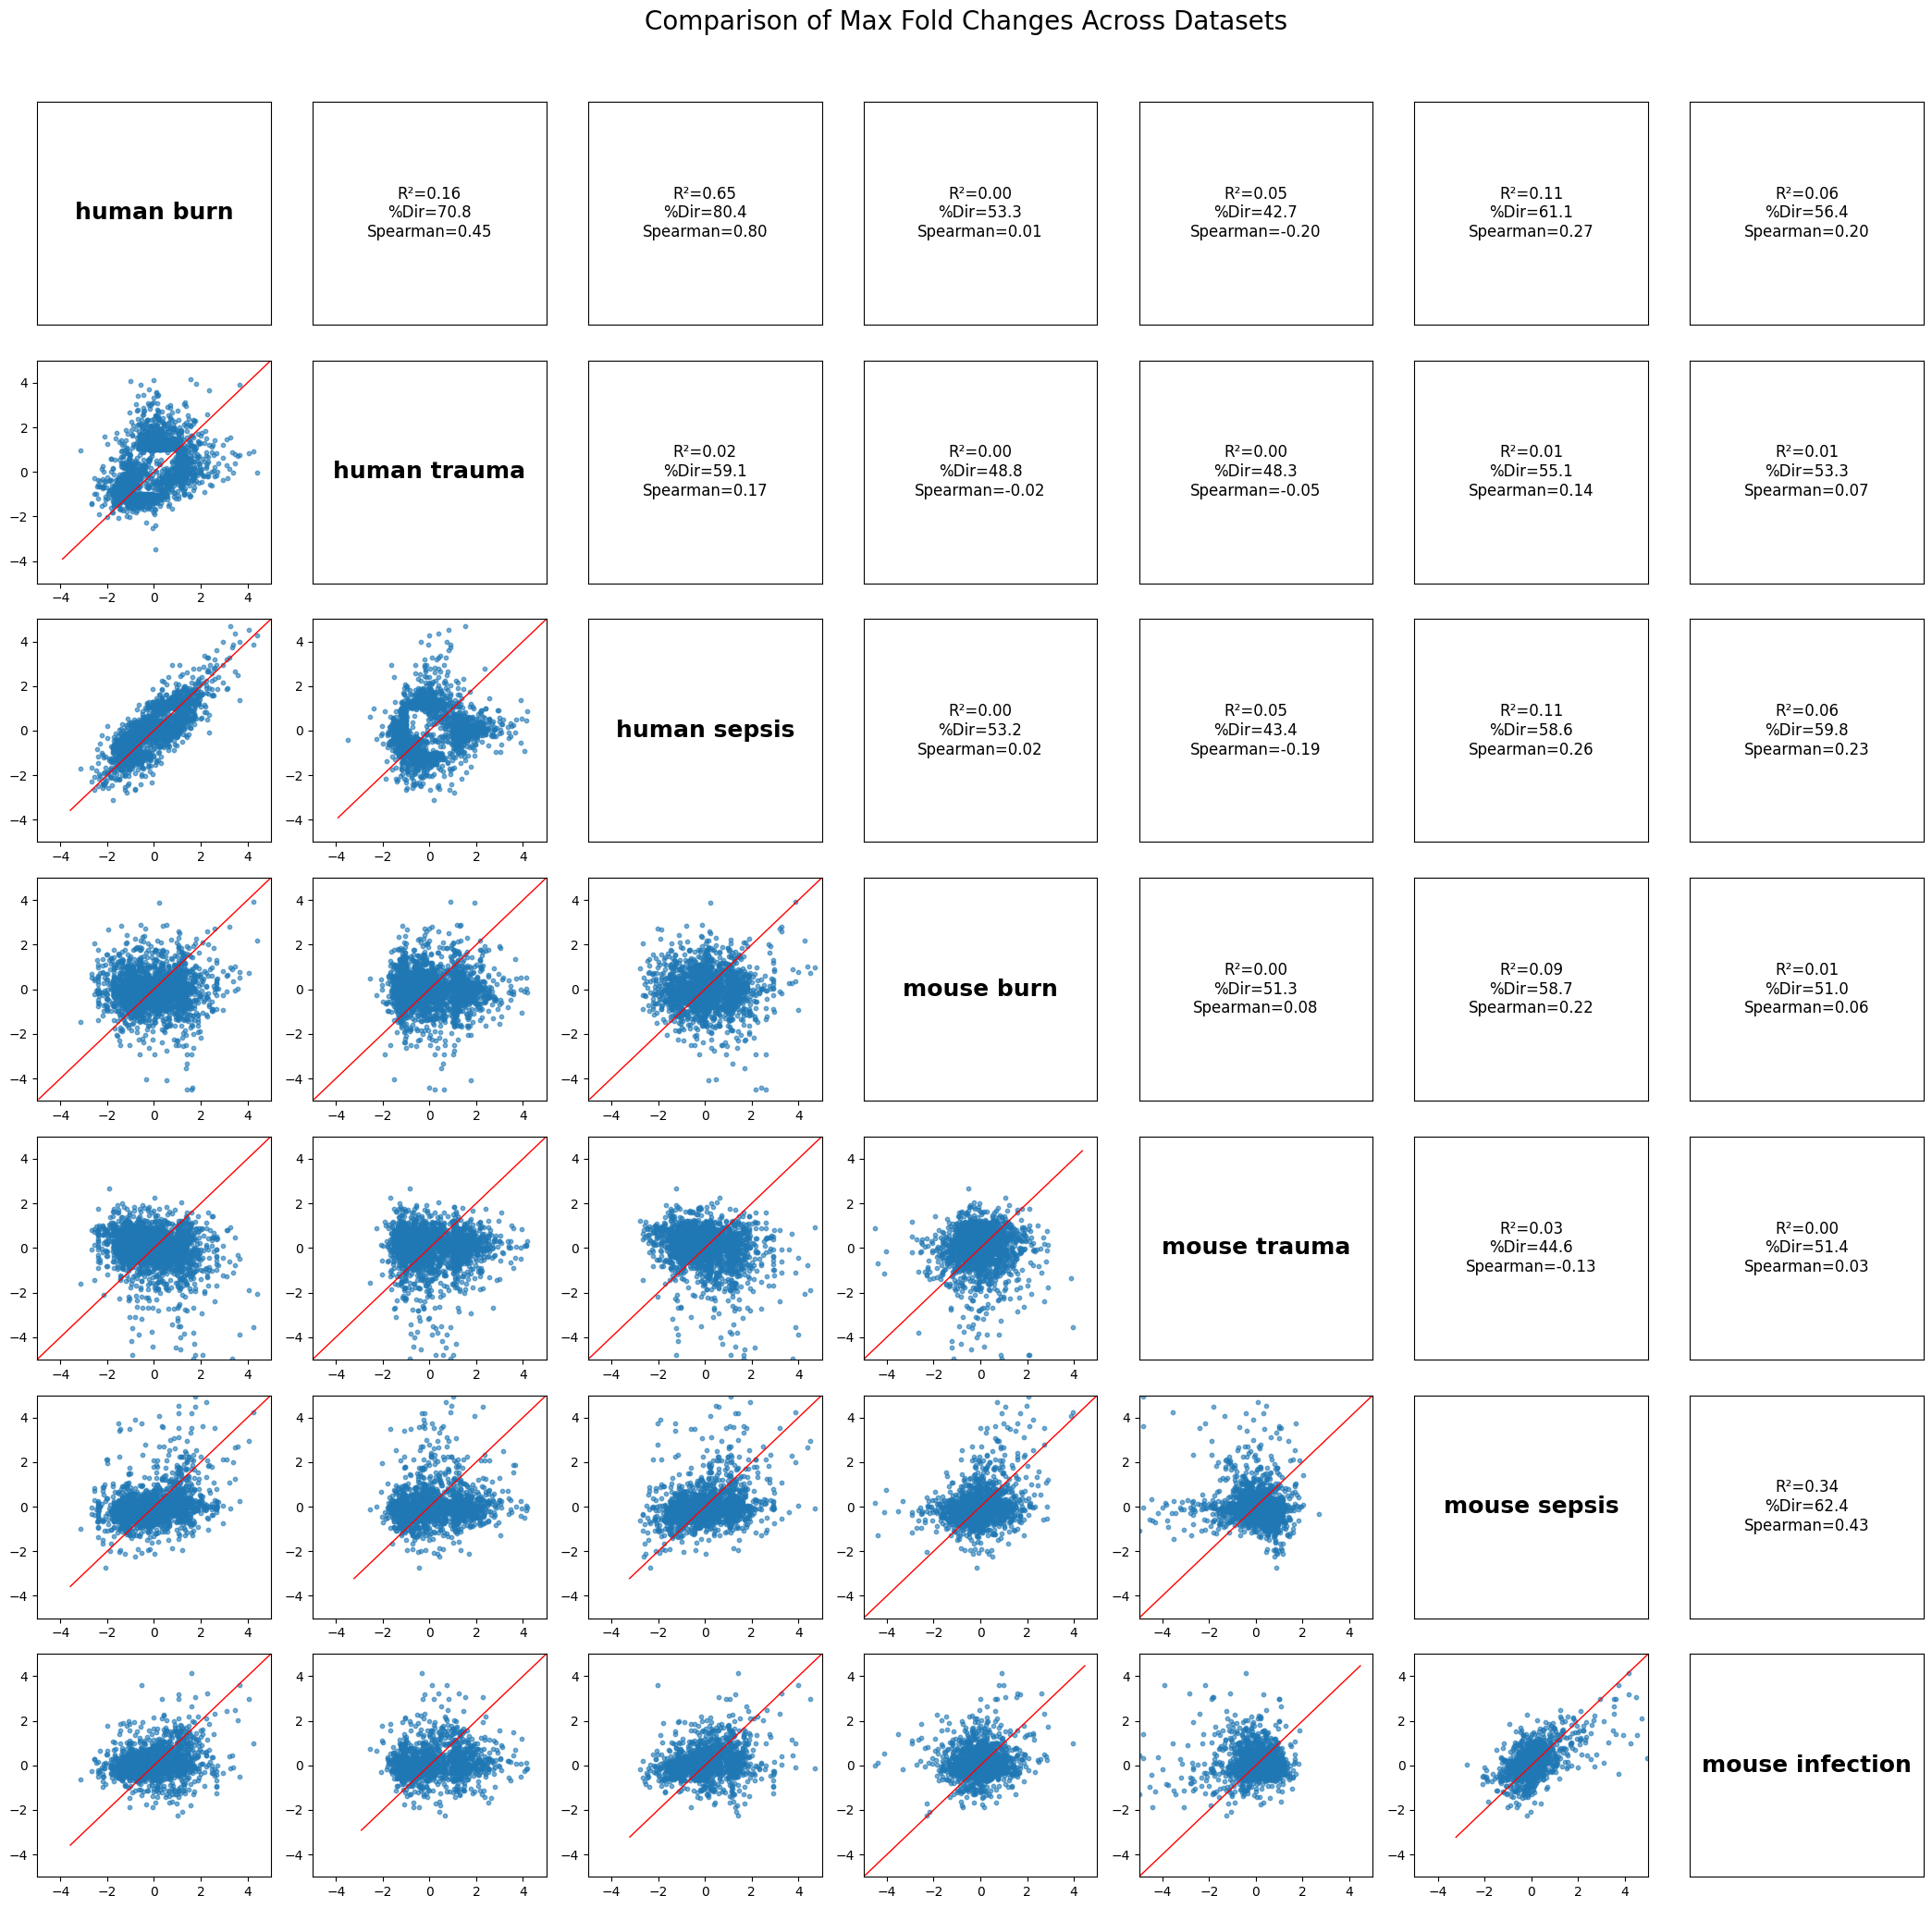

In [11]:
fig = make_comparison_grid(datasets_dict, orthologs)
fig.suptitle("Comparison of Max Fold Changes Across Datasets", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Greatly mimics

This will be similar in spirit, but keeping only the genes that are significantly differentially expressed in both human and mouse datasets.

#### Get significant genes

In [17]:
def compute_metrics(fc_x, fc_y):
    print(fc_x, fc_y)
    r, _ = pearsonr(fc_x, fc_y)
    r2 = r**2
    same_direction = (fc_x * fc_y > 0).sum()
    percent_same = same_direction / len(fc_x) * 100
    rho, _ = spearmanr(fc_x, fc_y)
    return {'R2_Pearson': r2, 'Percent_Same_Direction': percent_same, 'Spearman_rho': rho}

def plot_metrics_text(ax, metrics):
    text = f"R²={metrics['R2_Pearson']:.2f}\n" \
           f"%Dir={metrics['Percent_Same_Direction']:.1f}\n" \
           f"Spearman={metrics['Spearman_rho']:.2f}"
    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=12)

    # Keep a normal frame (spines) but remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)  # shows the outside box

def plot_scatter_fc(ax, fc_x, fc_y):
    ax.scatter(fc_x, fc_y, s=10, alpha=0.6)
    # ax.set_xticks([])
    # ax.set_yticks([])

    lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
    ax.plot(lims, lims, color='red', lw=1)

    for spine in ax.spines.values():
        spine.set_visible(True)

    # set x and y limits
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

def get_fc_vectors(dataset_i, dataset_j, orthologs_df):
    """
    Return aligned FC vectors for any pair of datasets.
    - Restricts to intersection of significant genes in both datasets.
    - Assumes human dataset is always passed first in cross-species comparisons.
    """
    adata_i, adata_j = dataset_i['adata'], dataset_j['adata']
    species_i, species_j = dataset_i['species'], dataset_j['species']

    # human-human
    if species_i == 'human' and species_j == 'human':
        sig_i = set(adata_i.var.index[adata_i.var['significant']])
        sig_j = set(adata_j.var.index[adata_j.var['significant']])
        genes = list(sig_i & sig_j)
        return (adata_i.var.loc[genes, 'log2FC'].astype(float).to_numpy(),
                adata_j.var.loc[genes, 'log2FC'].astype(float).to_numpy())

    # mouse-mouse
    elif species_i == 'mouse' and species_j == 'mouse':
        sig_i = set(adata_i.var.index[adata_i.var['significant']])
        sig_j = set(adata_j.var.index[adata_j.var['significant']])
        genes = list(sig_i & sig_j)
        return (adata_i.var.loc[genes, 'log2FC'].astype(float).to_numpy(),
                adata_j.var.loc[genes, 'log2FC'].astype(float).to_numpy())

    # human-mouse
    else:
        human_var, mouse_var = adata_i.var, adata_j.var
        sig_h = set(human_var.index[human_var['significant']])
        sig_m = set(mouse_var.index[mouse_var['significant']])

        fc_human_list, fc_mouse_list = [], []

        for h in sig_h:
            if h not in human_var.index:
                continue
            mouse_orthologs = orthologs_df.loc[
                orthologs_df['human_entrez'] == h, 'mouse_entrez'
            ].tolist()
            # only orthologs that are also significant
            mouse_orthologs = [m for m in mouse_orthologs if m in sig_m]
            if not mouse_orthologs:
                continue

            fc_human_list.extend([float(human_var.loc[h, 'log2FC'])] * len(mouse_orthologs))
            fc_mouse_list.extend(mouse_var.loc[mouse_orthologs, 'log2FC'].astype(float).tolist())

        return np.array(fc_human_list, dtype=float), np.array(fc_mouse_list, dtype=float)

def make_comparison_grid(datasets_dict, orthologs_df):
    """
    Create a comparison grid:
    - Diagonal: dataset names
    - Upper triangle: metrics
    - Lower triangle: scatter
    """
    dataset_names = list(datasets_dict.keys())
    n = len(dataset_names)
    fig, axes = plt.subplots(n, n, figsize=(3*n, 3*n))

    # Precompute all FC vectors
    fc_vectors = {}
    for i, name_i in enumerate(dataset_names):
        for j, name_j in enumerate(dataset_names):
            if j < i:
                # Reuse the symmetric pair
                fc_vectors[(i,j)] = fc_vectors[(j,i)]
            else:
                vectors = get_fc_vectors(datasets_dict[name_i], datasets_dict[name_j], orthologs_df)
                print(f"Computed FC vectors for {name_i} vs {name_j}, lengths: {len(vectors[0])}, {len(vectors[1])}")
                fc_vectors[(i,j)] = vectors

    # Diagonal: dataset names
    for i, name in enumerate(dataset_names):
        ax = axes[i,i]
        name = name.replace('_', ' ')
        ax.text(0.5, 0.5, name, ha='center', va='center', fontsize=18, fontweight='bold')
        
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(True)  # shows the outside box

    # Upper triangle: metrics
    for i in range(n):
        for j in range(i+1, n):
            ax = axes[i,j]
            fc_i, fc_j = fc_vectors[(i,j)]
            metrics = compute_metrics(fc_i, fc_j)
            plot_metrics_text(ax, metrics)

    # Lower triangle: scatter
    for i in range(1, n):
        for j in range(i):
            ax = axes[i,j]
            fc_i, fc_j = fc_vectors[(i,j)]
            plot_scatter_fc(ax, fc_i, fc_j)

    plt.tight_layout()
    return fig

Computed FC vectors for human_burn vs human_burn, lengths: 955, 955
Computed FC vectors for human_burn vs human_trauma, lengths: 275, 275
Computed FC vectors for human_burn vs human_sepsis, lengths: 431, 431
Computed FC vectors for human_burn vs mouse_burn, lengths: 105, 105
Computed FC vectors for human_burn vs mouse_trauma, lengths: 59, 59
Computed FC vectors for human_burn vs mouse_sepsis, lengths: 106, 106
Computed FC vectors for human_burn vs mouse_infection, lengths: 84, 84
Computed FC vectors for human_trauma vs human_trauma, lengths: 1158, 1158
Computed FC vectors for human_trauma vs human_sepsis, lengths: 122, 122
Computed FC vectors for human_trauma vs mouse_burn, lengths: 118, 118
Computed FC vectors for human_trauma vs mouse_trauma, lengths: 47, 47
Computed FC vectors for human_trauma vs mouse_sepsis, lengths: 56, 56
Computed FC vectors for human_trauma vs mouse_infection, lengths: 76, 76
Computed FC vectors for human_sepsis vs human_sepsis, lengths: 784, 784
Computed FC ve

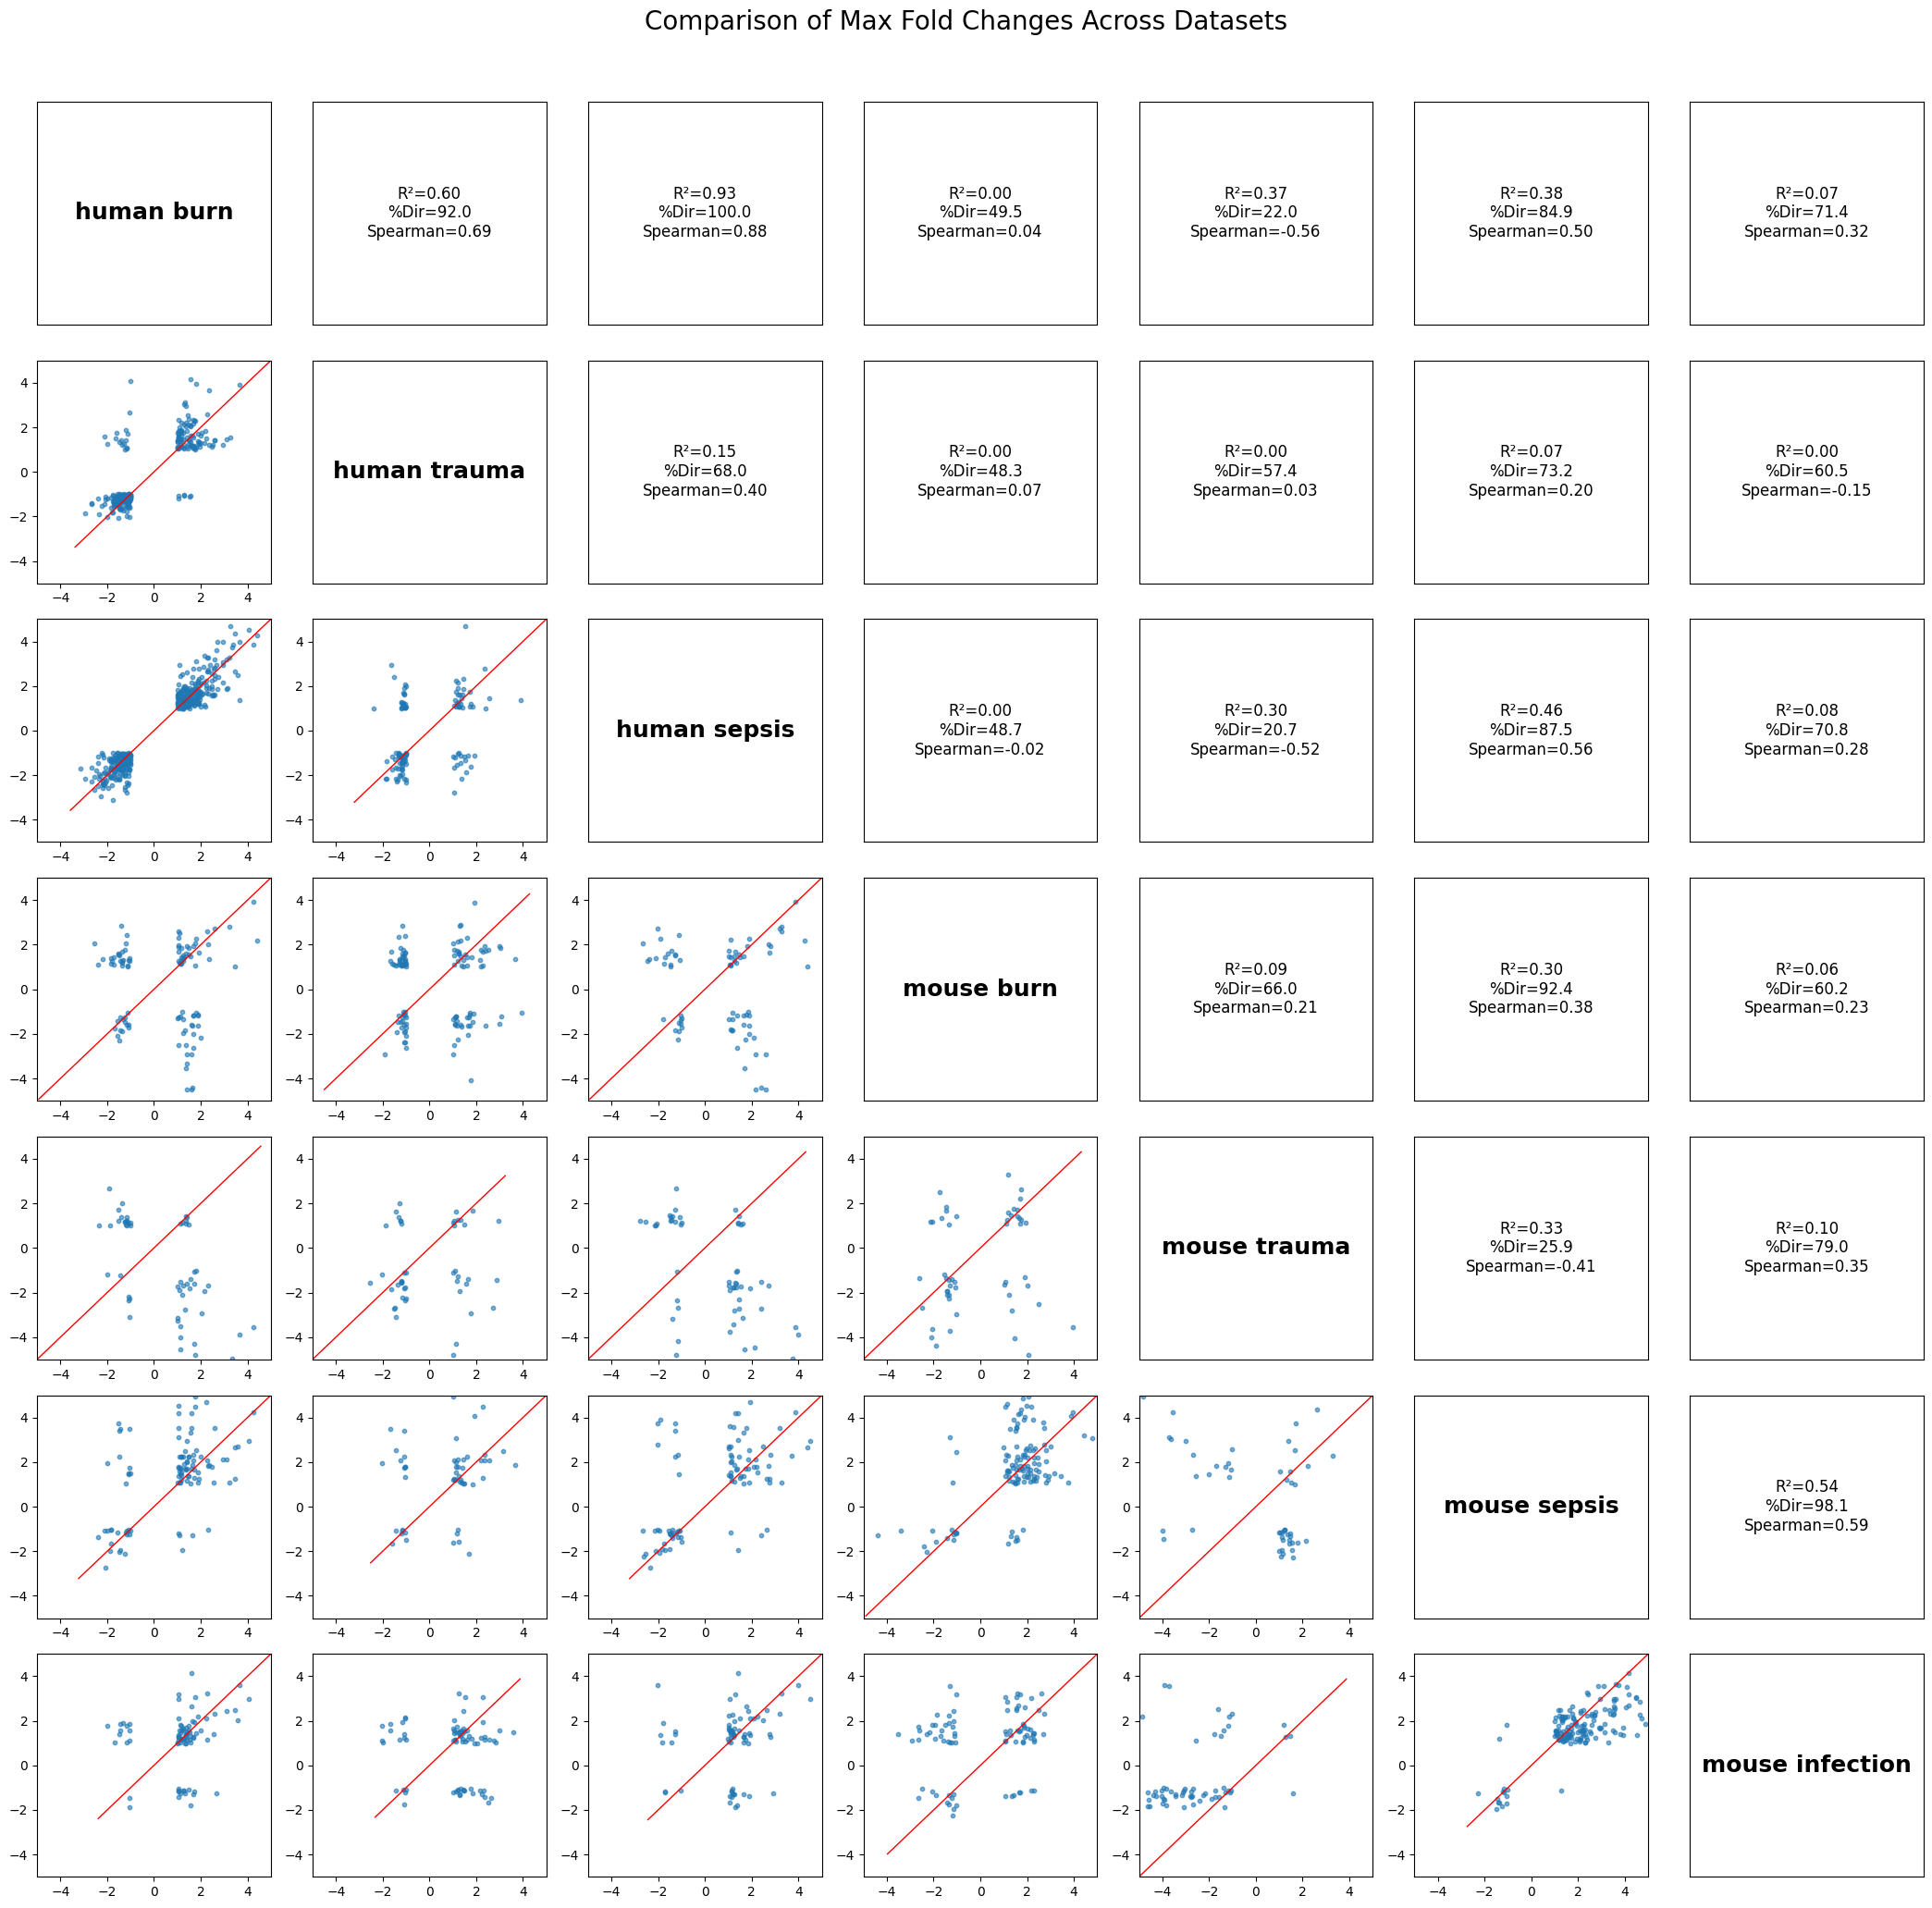

In [18]:
fig = make_comparison_grid(datasets_dict, orthologs)
fig.suptitle("Comparison of Max Fold Changes Across Datasets", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()